<a href="https://colab.research.google.com/github/jihankaruniaa/Machine-Learning/blob/main/Jobsheet%2010%20RNN%20Praktikum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Job Sheet 10 : Recurrent Neural Network (RNN)

### Praktikum 1 - RNN untuk Analisis Sentimen

#### Setup

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
 plt.plot(history.history[metric])
 plt.plot(history.history['val_'+metric], '')
 plt.xlabel("Epochs")
 plt.ylabel(metric)
 plt.legend([metric, 'val_'+metric])

#### Setup input pipeline
Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Of the three remakes of this plot, I like them all, I have all three on VHS and in addition have a copy of this one on DVD. There is just enough variation in the scripts to make all three entertaining and re-watchable. In addition has any other film been remade three times with such all star casts in each? Of course the main stars in this one are great, but the supporting actors are also superb. I particularly like William Tracy as Pepi. He was such a scene stealer that I have searched to find other movies he is in. He appeared in many, but most are not available. As the other comments, I also say - buy this one.'
 b"Michael Williams, who works for BBC, finds a somehow impressive Italian picture which gets mixed in the material of his ongoing task titled DIABOLICAL ART: A DOCUMENTARY. But since his wife's mysterious death her daughter, Emily, has been emotionally disturbed, so he goes Spoleto, where the problematic picture is, with her and her nanny, Jill. And there is a Cou

#### Buat Teks Encoder

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  5,   2, 290, ...,   0,   0,   0],
       [487,   1,  37, ...,   0,   0,   0],
       [  1, 272,   1, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

- Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".

- Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Of the three remakes of this plot, I like them all, I have all three on VHS and in addition have a copy of this one on DVD. There is just enough variation in the scripts to make all three entertaining and re-watchable. In addition has any other film been remade three times with such all star casts in each? Of course the main stars in this one are great, but the supporting actors are also superb. I particularly like William Tracy as Pepi. He was such a scene stealer that I have searched to find other movies he is in. He appeared in many, but most are not available. As the other comments, I also say - buy this one.'
Round-trip:  of the three [UNK] of this plot i like them all i have all three on [UNK] and in [UNK] have a [UNK] of this one on dvd there is just enough [UNK] in the [UNK] to make all three entertaining and [UNK] in [UNK] has any other film been [UNK] three times with such all star [UNK] in each of course the main stars in this one are great but the supporting ac

#### Buat Model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])


[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[0.00297468]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(tf.constant([sample_text, padding]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
[0.00297468]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#### Train Model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 708s 2s/step - accuracy: 0.5300 - loss: 0.6711 - val_accuracy: 0.8161 - val_loss: 0.4550
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 735s 2s/step - accuracy: 0.8226 - loss: 0.3896 - val_accuracy: 0.8427 - val_loss: 0.3331
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 786s 2s/step - accuracy: 0.8502 - loss: 0.3432 - val_accuracy: 0.8656 - val_loss: 0.3160
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 700s 2s/step - accuracy: 0.8554 - loss: 0.3263 - val_accuracy: 0.8536 - val_loss: 0.3329
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 705s 2s/step - accuracy: 0.8600 - loss: 0.3217 - val_accuracy: 0.8526 - val_loss: 0.3204
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 752s 2s/step - accuracy: 0.8655 - loss: 0.3125 - val_accuracy: 0.8521 - val_loss: 0.3300
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 740s 2s/step - accuracy: 0.8688 - loss: 0.3031 - val_accuracy: 0.8687 - val_loss: 0.3157
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 713s 2s/step - accuracy: 0.8685 - loss: 0.3012 - val_accu

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 162s 415ms/step - accuracy: 0.8531 - loss: 0.3148
Test Loss: 0.3138822019100189
Test Accuracy: 0.8530799746513367


(0.0, 0.6212395995855331)

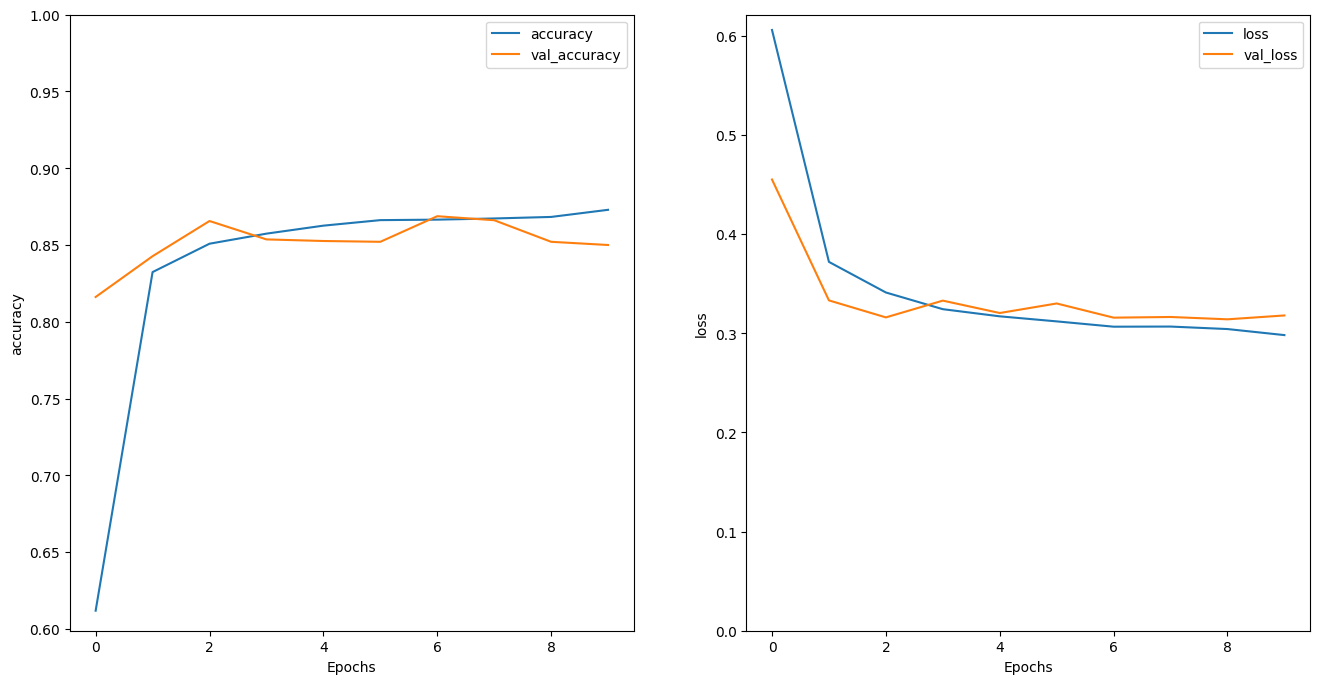

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


#### Stack two or more LSTM layers

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1380s 3s/step - accuracy: 0.5142 - loss: 0.6778 - val_accuracy: 0.8276 - val_loss: 0.4262
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1372s 4s/step - accuracy: 0.8183 - loss: 0.4232 - val_accuracy: 0.8339 - val_loss: 0.3570
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1379s 3s/step - accuracy: 0.8449 - loss: 0.3591 - val_accuracy: 0.8604 - val_loss: 0.3488
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1412s 3s/step - accuracy: 0.8562 - loss: 0.3388 - val_accuracy: 0.8531 - val_loss: 0.3321
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1398s 3s/step - accuracy: 0.8667 - loss: 0.3138 - val_accuracy: 0.8562 - val_loss: 0.3453
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1415s 3s/step - accuracy: 0.8679 - loss: 0.3182 - val_accuracy: 0.8573 - val_loss: 0.3232
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1379s 4s/step - accuracy: 0.8650 - loss: 0.3129 - val_accuracy: 0.8687 - val_loss: 0.3284
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1360s 3s/step - accuracy: 0.8714 - loss: 0.3028 - 

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 283s 723ms/step - accuracy: 0.8567 - loss: 0.3180
Test Loss: 0.31745049357414246
Test Accuracy: 0.8563200235366821


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[-1.9891644]]


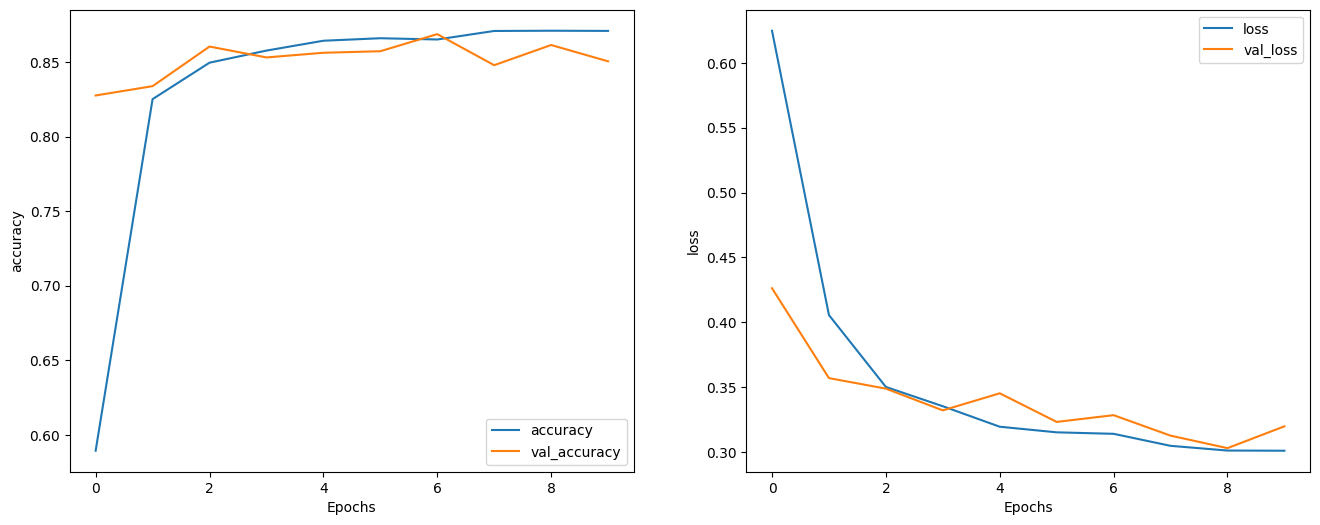

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')